In [1]:
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
import matplotlib.pyplot as plt

In [66]:
tf.test.is_gpu_available()

2021-09-22 05:31:49.166867: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-22 05:31:49.167451: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


False

In [59]:
tf.config.list_physical_devices('GPU')

[]

In [60]:
os.environ['CUDA_DVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Epoch & Batch 수를 어떻게 정할지???????????????????????????????????????


In [27]:
print(os.getcwd())

/home/jupyter/Alzheimer_project


In [28]:
LEARNING_RATE = 0.001
N_EPOCHS = 30
N_BATCHS = 100

IMAGE_SIZE = [208, 176]

In [29]:
train_dir = '/home/jupyter/Alzheimer_project/Alzheimer_s Dataset/train'
test_dir = '/home/jupyter/Alzheimer_project/Alzheimer_s Dataset/test'

In [30]:
# train의 총 이미지 개수
len(glob(os.path.join(train_dir,'*/*.jpg')))

5121

In [31]:
# test의 총 이미지 개수
len(glob(os.path.join(test_dir,'*/*.jpg')))

1279

In [32]:
len(glob(os.path.join(train_dir, 'NonDemented', '*.jpg')))

2560

In [33]:
# train data의 각 class별 데이터 개수
train_class_dir = glob(os.path.join(train_dir, '*'))

for class_name in train_class_dir:
  class_count = len(glob(os.path.join(class_name,'*.jpg')))
  print(os.path.basename(class_name), class_count)


MildDemented 717
ModerateDemented 52
VeryMildDemented 1792
NonDemented 2560


In [34]:
# train data의 각 class별 데이터 개수
test_class_dir = glob(os.path.join(test_dir, '*'))

for class_name in test_class_dir:
  class_count = len(glob(os.path.join(class_name,'*.jpg')))
  print(os.path.basename(class_name), class_count)


MildDemented 179
ModerateDemented 12
VeryMildDemented 448
NonDemented 640


In [35]:
# 이미지 크기 확인

brain_img = cv2.imread('/home/jupyter/Alzheimer_project/Alzheimer_s Dataset/train/ModerateDemented/moderateDem0.jpg')  
# type(brain_img)
brain_img.shape

(208, 176, 3)

In [36]:
# ImageDataGenerator 생성
train_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

# pytorch에서 어떻게 데이터를 넣어줄건지????????????????????????????????????????

In [37]:
# raw data 연결
# pytorch에서 어떻게 데이터를 넣어줄건지??????????????????????????????????????????
train_iter = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SIZE,
                                               class_mode='categorical',
                                               batch_size=N_BATCHS)
test_iter = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SIZE,
                                             class_mode='categorical',
                                             batch_size=N_BATCHS)

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [38]:
# Label 확인 - iterator.class_indices
train_iter.class_indices

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

In [39]:
test_iter.class_indices

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

In [40]:
# 1 에폭당 step 수 - len(iterator)
len(train_iter), len(test_iter)

(52, 13)

In [41]:
# iterator를 이용해서 데이터 조회
batch = next(train_iter)
print(type(batch))
print(type(batch[0]), type(batch[1]))
print(batch[0].shape, batch[1].shape)  #(batch 크기만큼의 iamge, batch 크기 만큼의 label)

<class 'tuple'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(100, 208, 176, 3) (100, 4)


## 모델 형성

In [51]:
def create_model():
    model = keras.Sequential()
    
    model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=(208, 176, 3)))
    model.add(layers.MaxPool2D(padding='same'))

    model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))

    model.add(layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))

    model.add(layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))

    # Dense
    model.add(layers.Flatten())
    # Dropout
    model.add(layers.Dropout(rate=0.5))
    model.add(layers.Dense(units=512, activation='relu'))
    model.add(layers.Dense(units=4, activation='softmax'))  # 다중분류 출력 레이어

    return model

In [52]:
model = create_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 208, 176, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 104, 88, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 104, 88, 64)       36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 52, 44, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 44, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 22, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 22, 128)       1

In [25]:
keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [44]:
# weight 저장 경로
save_dir = os.path.join('/home/jupyter/Alzheimer_project/brain', 'brain_model', 'test1')
print(save_dir)
os.makedirs(save_dir, exist_ok=True)

/home/jupyter/Alzheimer_project/brain/brain_model/test1


In [45]:
save_file_path = os.path.join(save_dir, 'weights_ckpt')  # 저장할 weight 파일경로

mc_callback = keras.callbacks.ModelCheckpoint(filepath=save_file_path,
                                              save_weights_only=True,
                                              save_best_only=True,
                                              monitor='val_loss',
                                              verbose=2)

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10)

## Model Training(학습)

In [53]:
# train dataset = ImageDataGenerator를 지정 (iterator)
# steps_per_epoch : 1에폭당 몇 step인지
hist = model.fit(train_iter, epochs=N_EPOCHS,
                 steps_per_epoch=len(train_iter),
                 validation_data=test_iter,
                 validation_steps=len(test_iter),
                 callbacks=[mc_callback, es_callback])

Epoch 1/30
52/52 [==============================] - 259s 5s/step - loss: 1.1321 - accuracy: 0.4884 - val_loss: 1.0301 - val_accuracy: 0.5152

Epoch 00001: val_loss did not improve from 0.85163
Epoch 2/30
52/52 [==============================] - 261s 5s/step - loss: 1.0009 - accuracy: 0.5181 - val_loss: 0.9784 - val_accuracy: 0.5223

Epoch 00002: val_loss did not improve from 0.85163
Epoch 3/30
52/52 [==============================] - 262s 5s/step - loss: 0.9260 - accuracy: 0.5538 - val_loss: 0.9881 - val_accuracy: 0.5332

Epoch 00003: val_loss did not improve from 0.85163
Epoch 4/30
52/52 [==============================] - 258s 5s/step - loss: 0.8718 - accuracy: 0.5958 - val_loss: 0.9348 - val_accuracy: 0.5410

Epoch 00004: val_loss did not improve from 0.85163
Epoch 5/30
52/52 [==============================] - 259s 5s/step - loss: 0.7907 - accuracy: 0.6467 - val_loss: 0.8703 - val_accuracy: 0.6067

Epoch 00005: val_loss did not improve from 0.85163
Epoch 6/30
52/52 [=================

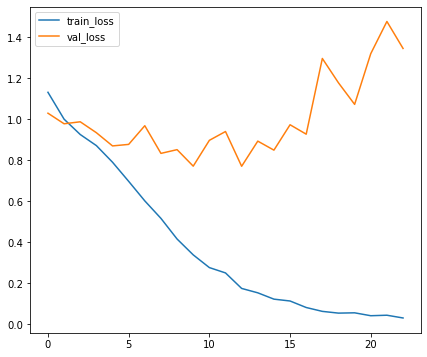

In [54]:
plt.figure(figsize=(7,6))
plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='val_loss')

plt.legend()
plt.show()

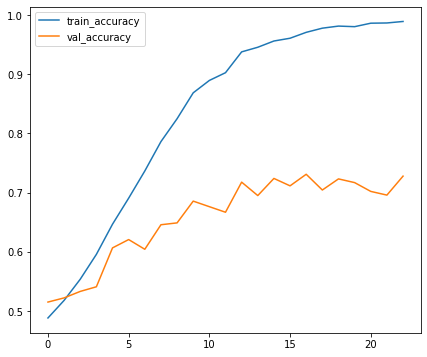

In [55]:
plt.figure(figsize=(7,6))
plt.plot(hist.history['accuracy'], label='train_accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')

plt.legend()
plt.show()

In [56]:
# 저장된 모델 조회
save_model = create_model()
save_model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [57]:
save_model.evaluate(test_iter)

13/13 [==============================] - 16s 1s/step - loss: 1.3710 - accuracy: 0.4550


[1.3709750175476074, 0.4550429880619049]